# **IMPORTAÇÕES**

In [ ]:
import librosa as librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import zipfile
import random

# **DOCUMENTAÇÕES E LINKS ÚTEIS**

https://librosa.org/doc/latest/

Base de Dados:
https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition

# **INSTRUÇÕES**

Para executar, esse colab precisa acessar arquivos específicos, a forma ideal é liberar o acesso ao seu google Drive e seguir as instruções a seguir.

É necessário baixar os arquivos dos audios no seu Drive, para isso, as instruções estão indicadas na sessão **IMPORTAR DADOS** abaixo
* A pasta que contém o arquivos dos audios precisam estar no seu drive, dentro de uma pasta chamada Sinais e Sistemas
* O código foi projetado para operar sobre uma pasta AUDIO que contenha as pastas FAKE e REAL com os audios correspondentea

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **IMPORTAR DADOS**

Se for a sua primeira vez executando esse colab, baixe esse arquivo zip e o salve na pasta raíz do seu drive:
https://drive.google.com/file/d/1fpl4EArgqflnwK5E76i-QiTf-K5wYqI0/view?usp=drive_link

Execute as duas células abaixo, elas irão descompactar o arquivo zip que contém os audios a serem manipulados no seu drive

In [ ]:
def unzip(path, destiny):
  with zipfile.ZipFile(path, 'r') as zip_ref:
      zip_ref.extractall(destiny)

In [ ]:
unzip("/content/drive/MyDrive/SS-20240320T133811Z-001.zip", "/content/drive/MyDrive/")

Alternativamente, você também pode adicionar um atalho à pasta que estamos utilizando na execução do projeto na pasta raíz do seu drive


1.   Entre em https://drive.google.com/drive/folders/1iXimH2OSg_BgO_zlXrVId4HHio1eMCMU?usp=drive_link
2.   Clique com o botão direito sobre o nome da pasta "Sinais e Sistemas"
3.   Selecione a opção Organizar
4.   Selecione a opção "adicionar atalho"
5.   Selecione a pasta raíz do seu drive


# **CARREGAR DADOS**

Com os arquivos descompactados na pasta Sinais e Sistemas do seu drive, pode dar prosseguimento na importação dos dados para o Colab que está executando

Vamos agora identificar os diretórios dos arquivos de áudio, listar os arquivos de áudio e criar uma lista de arquivos e categorias:

In [ ]:
# Diretórios dos áudios
real_audio_dir = "/content/drive/MyDrive/Sinais e Sistemas/KAGGLE/AUDIO/REAL"
fake_audio_dir = "/content/drive/MyDrive/Sinais e Sistemas/KAGGLE/AUDIO/FAKE"

samples_audio_dir = "/content/drive/MyDrive/Sinais e Sistemas/KAGGLE/AUDIO/SAMPLES/REAL"

real_csv_dir = "/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/REAL"
fake_csv_dir = "/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE"
samples_csv_dir = "/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/SAMPLES"

# Função para listar os arquivos em um diretório
def listar_arquivos(diretorio):
    return [os.path.join(diretorio, arquivo) for arquivo in os.listdir(diretorio)]

# Listar arquivos e criar lista de arquivos e categorias
arquivos_reais = listar_arquivos(real_audio_dir)
arquivos_fakes = listar_arquivos(fake_audio_dir)
arquivos_samples = listar_arquivos(samples_audio_dir)

csv_reais = listar_arquivos(real_csv_dir)
csv_fakes = listar_arquivos(fake_csv_dir)
csv_samples = listar_arquivos(samples_csv_dir)

# Criar uma lista de tuplas (caminho do arquivo, categoria)
dados_audio = [(arquivo, 'real') for arquivo in arquivos_reais] + [(arquivo, 'fake') for arquivo in arquivos_fakes]

# **POR QUE NÃO REALIZAR O PRÉ-PROCESSAMENTO DE DADOS?**

 A escolha deliberada de não realizar um pré-processamento extensivo nos áudios é baseada nas características intrínsecas da base de dados, bem como no objetivo de possibilitar a identificação em cenários amplos. A seguir, apresentamos as principais razões para essa decisão:

1. **Variação Realista:**
   - A base de dados inclui áudios de oito indivíduos distintos, abrangendo uma variedade de contextos, como discursos de vitória, discursos de premiações e monólogos de despedida. A presença de diferentes condições acústicas, níveis de qualidade e durações de áudio contribui para uma representação realista e diversificada.

2. **Preservação de Ambiente e Estilo:**
   - O processo de geração de deepfakes envolve uma etapa chamada Retrieval-based Voice Conversion (RVC). Durante essa etapa, a voz original é convertida para outra individualidade sem alterar o ambiente de fundo. A separação prévia dos vocais e dos acompanhamentos garante que o estilo da voz deepfake não seja convertido junto com possíveis ruídos de fundo, como aplausos ou risadas. Essa abordagem visa preservar sons ambientais enquanto converte apenas a voz do falante.

3. **Respeito à Integridade dos Dados:**
   - Manter os áudios em seu estado original, sem pré-processamento extensivo, preserva a integridade dos dados fornecidos na base de dados. Isso reflete a decisão consciente de respeitar as características únicas de cada áudio e evitar modificações que possam influenciar negativamente na representação fidedigna dos sinais de áudio.

Essa estratégia visa garantir que o modelo de reconhecimento de sons seja treinado e avaliado em condições semelhantes às encontradas na base de dados original, proporcionando uma abordagem autêntica para a tarefa em questão.

# **ANÁLISE E TRATAMENTO DE DADOS**

Explorar visualmente os dados é uma etapa valiosa para entender melhor as características e padrões presentes nos áudios.
Vamos primeiro visualizar as formas de onda de alguns desses dados:

In [ ]:
def showAudio(audio_path):
  plt.figure(figsize=(15, 5))
  waveform, sr = librosa.load(audio_path, sr=None)
  librosa.display.waveshow(waveform, sr=sr)

  plt.title('Forma de Onda - Áudio Real')
  plt.xlabel('Tempo (s)')
  plt.ylabel('Amplitude')
  plt.show()

In [ ]:
# showAudio(real_audio_dir + "/biden-original.wav")

In [ ]:
# showAudio(fake_audio_dir + "/biden-to-taylor.wav")

A análise visual das formas de onda sugere que o áudio "biden-to-taylor.wav" apresenta padrões irregulares na amplitude, indicando características associadas a deepfakes. Essa diferença pode ser explorada ainda mais por meio de técnicas de processamento de áudio e extração de características para desenvolver um modelo de classificação robusto capaz de distinguir entre áudios reais e deepfakes. O desafio reside em identificar padrões sutis que podem não ser visíveis a olho nu, mas que podem ser capturados por algoritmos de aprendizado de máquina.

Vamos analisar agora os espectogramas. Os espectrogramas são representações visuais da intensidade das frequências em relação ao tempo. Eles podem revelar padrões de frequência ao longo do tempo.

### Short-Time Fourier Transform (STFT)

A Transformada de Fourier de Curto Prazo (STFT) é uma técnica utilizada para analisar a frequência de um sinal em relação ao tempo. Em vez de calcular a transformada de Fourier de um sinal completo, a STFT divide o sinal em pequenos segmentos temporais e calcula a transformada de Fourier para cada segmento. Isso é essencial para analisar sinais não estacionários, ou seja, sinais cujas características mudam ao longo do tempo.

A biblioteca librosa oferece uma função conveniente, `librosa.stft`, para calcular a STFT de um sinal de áudio. Essa função aceita diversos parâmetros, incluindo o sinal de áudio, o tamanho da janela de Fourier (`n_fft`), o tamanho do salto entre segmentos consecutivos (`hop_length`), e o tamanho da janela de cada segmento (`win_length`).

A saída da função é uma matriz complexa que representa a STFT do sinal de áudio. Essa matriz pode ser utilizada para extrair informações espectrais ao longo do tempo.

Para uma melhor compreensão visual, a função `librosa.display.specshow` pode ser empregada para exibir o espectrograma associado à STFT, revelando padrões de frequência e variações temporais no sinal de áudio.


In [ ]:
def displaySpectogram(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    D = librosa.stft(y, n_fft=2048, hop_length=512, win_length=2048, window='hann')
    DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma')
    plt.tight_layout()
    plt.show()

In [ ]:
# displaySpectogram(real_audio_dir + "/biden-original.wav")

In [ ]:
# displaySpectogram(fake_audio_dir + "/biden-to-taylor.wav")

A análise dos espectrogramas destaca diferenças marcantes entre os áudios "biden-original.wav" e "biden-to-taylor.wav". Enquanto o áudio real exibe padrões suaves e consistentes de frequência, o deepfake apresenta oscilações mais pronunciadas e variações irregulares.

# **EXTRAÇÃO DE CARACTERÍSTICAS**

Nesta etapa, realizamos a extração de características dos áudios para utilizá-las como entradas em nosso modelo de classificação. Utilizamos diversas técnicas para extrair informações relevantes dos sinais de áudio.

## Características que serão extraídas

### Chromagram

O *Chromagram* é uma representação do espectro de áudio no domínio da frequência tonal, calculado a partir da Transformada de Fourier de Tempo Curto (Short-Time Fourier Transform - STFT). Ele fornece informações sobre a distribuição da energia em diferentes faixas de tons musicais, sendo útil para identificar padrões tonais e melódicos nas gravações de áudio.

<center>$SG(m, k) = |X(m, k)|$</center>

### Spectral Centroid (SC)

O *Spectral Centroid* é a localização do centro de massa no espectro de áudio. Ele fornece uma medida da "brilhância" ou "tonalidade" do som, indicando a frequência média ponderada das amplitudes no sinal. Valores mais altos de *Spectral Centroid* geralmente indicam sons mais agudos, enquanto valores mais baixos indicam sons mais graves.

<center>$SC(m) = \frac{\sum_{k} [k \cdot SG(m, k)]}{\sum_{k} [SG(m, k)]}$</center>

### Spectral Bandwidth (SB)

A *Spectral Bandwidth* é a largura do espectro de frequência. Ela representa a dispersão das frequências no espectro de áudio e fornece informações sobre a "cor" ou "timbre" do som. A *Spectral Bandwidth* é calculada como a diferença entre as frequências ao redor do *Spectral Centroid*.

<center>$SB(m) = \sqrt{\frac{\sum_{k} [(k-SC(m))^2 \cdot SG(m, k)]}{\sum_{k} [SG(m, k)]}}$</center>

### Spectral Rolloff (SR)

O *Spectral Rolloff* é a frequência abaixo da qual uma porcentagem específica da energia total do espectro está contida. Ele fornece uma medida da inclinação do espectro de áudio e é útil para caracterizar a "brilhância" ou "agudeza" do som.
(SR é calculado via a frequência abaixo de 85% da energia espectral total)


### Zero Crossing Rate (ZCR)

A *Zero Crossing Rate* é a taxa na qual o sinal de áudio muda de sinal, ou seja, cruza o eixo x = 0 e muda de positivo para negativo ou vice-versa. Ela fornece informações sobre a frequência de variação do sinal de áudio e é útil para caracterizar a "textura" ou "aspereza" do som.

<center>$ZCR(m) = \frac{1}{2N} \sum_{n=1}^{N-1} [|sgn(x[n]) - sgn(x[n-1])|]$</center>


### Root Mean Square (RMS)

O *Root Mean Square* é uma medida da amplitude média do sinal de áudio. Ele fornece uma medida da "energia" ou "intensidade" do som, sendo útil para caracterizar a "loudness" ou "volume" do áudio.

<center>$RMS(m) = \sqrt{\frac{1}{N} \sum_{n=0}^{N-1} [(x[n])^2]}$</center>

### Mel-Frequency Cepstral Coefficients (MFCCs)

Os *Mel-Frequency Cepstral Coefficients* (MFCCs) são coeficientes cepstrais de frequência mel que representam as características mais significativas do espectro de áudio. Eles são calculados aplicando uma janela triangular ao espectro de potência, seguido por uma Transformada Cosseno Discreta (Discrete Cosine Transform - DCT). Os MFCCs capturam informações sobre a forma e a distribuição do espectro de áudio, sendo amplamente utilizados em aplicações de reconhecimento de voz e música.

## Funções de Extração de Características

In [ ]:
def extract_mfcc(audio_segment, sample_rate):
    features = librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=20)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_chroma_stft(audio_segment, sample_rate):
    features = librosa.feature.chroma_stft(y=audio_segment, sr=sample_rate)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_rms(audio_segment):
    features = librosa.feature.rms(y=audio_segment)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_spectral_centroid(audio_segment, sample_rate):
    features = librosa.feature.spectral_centroid(y=audio_segment, sr=sample_rate)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_spectral_bandwidth(audio_segment, sample_rate):
    features = librosa.feature.spectral_bandwidth(y=audio_segment, sr=sample_rate)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_spectral_rolloff(audio_segment, sample_rate):
    features = librosa.feature.spectral_rolloff(y=audio_segment, sr=sample_rate)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_zero_crossing_rate(audio_segment):
    features = librosa.feature.zero_crossing_rate(y=audio_segment)
    avg_features = np.mean(features, axis=1)
    return avg_features

## Processamento dos Áudios
Aqui extraímos as features dos audios fornecidos

In [ ]:
def process_audio(label, audio_file, segment_duration=20):
    audio, sample_rate = librosa.load(audio_file, sr=None)
    num_segments = int(len(audio) / (sample_rate * segment_duration))

    features_list = []

    for i in range(num_segments):
        start = i * sample_rate * segment_duration
        end = (i + 1) * sample_rate * segment_duration
        segment = audio[start:end]
        features_chroma = extract_chroma_stft(segment, sample_rate)
        features_rms = extract_rms(segment)
        features_spectral_centroid = extract_spectral_centroid(segment, sample_rate)
        features_spectral_bandwidth = extract_spectral_bandwidth(segment, sample_rate)
        features_spectral_rolloff = extract_spectral_rolloff(segment, sample_rate)
        features_zero_crossing_rate = extract_zero_crossing_rate(segment)
        features_mfcc = extract_mfcc(segment, sample_rate)

        # Arredondar os valores para até a 6ª casa decimal
        features_chroma = np.round(features_chroma, 6)
        features_rms = np.round(features_rms, 6)
        features_spectral_centroid = np.round(features_spectral_centroid, 6)
        features_spectral_bandwidth = np.round(features_spectral_bandwidth, 6)
        features_spectral_rolloff = np.round(features_spectral_rolloff, 6)
        features_zero_crossing_rate = np.round(features_zero_crossing_rate, 6)
        features_mfcc = np.round(features_mfcc, 6)

        features_list.append(np.concatenate((features_chroma, features_rms, features_spectral_centroid, features_spectral_bandwidth, features_spectral_rolloff, features_zero_crossing_rate, features_mfcc)))

    feature_names = [f'chroma_{i}' for i in range(features_chroma.shape[0])] + ['rms', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate'] + [f'mfcc_{i}' for i in range(features_mfcc.shape[0])]

    df = pd.DataFrame(features_list, columns=feature_names)
    df['LABEL'] = label
    return df


In [ ]:
def saveAudioToCSV(file_name, data_df, label):
  file_name_2, _ = os.path.splitext(os.path.basename(file_name))

  new_file_name = file_name_2 + '.csv'

  csv_filename = "/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/" + label + os.path.basename(new_file_name)
  data_df.to_csv(csv_filename, index=False)

  # print(f"Arquivo CSV salvo em: {csv_filename}")

In [ ]:
# arquivos_real = listar_arquivos(real_audio_dir)

# audio_features = []

# for filename in arquivos_real:
#     if filename.endswith(".wav"):
#         features_df = process_audio("REAL", filename)
#         saveAudioToCSV(filename, features_df, "REAL-1S/")
#         audio_features.append(features_df.values.tolist())

In [ ]:
# arquivos_fake = listar_arquivos(fake_audio_dir)

# oradores = ["biden", "obama", "musk", "taylor", "margot", "trump", "ryan", "linus"]

# for filename in arquivos_fake:
#     if filename.endswith(".wav"):
#         features_df = process_audio("FAKE", filename)
#         saveAudioToCSV(filename, features_df, "FAKE-1S/")

In [ ]:
# arquivos_samples = listar_arquivos(samples_audio_dir)

# for filename in arquivos_samples:
#       features_df = process_audio("REAL", filename)
#       saveAudioToCSV(filename, features_df, "SAMPLES/")

Aqui estamos concatenando os arquivos CSV salvos com as features de 24 audios, dois falsos selecionados para cada real, mas os dados reais são concatenados duas vezes, ou seja, os dados desses estão duplicados para balancear o dataset que iremos usar no treinamento


# BREVE EXPLORAÇÃO DOS DADOS

Nesta seção, realizamos uma breve análise inicial do conjunto de dados para obter insights valiosos sobre as características que coletamos.


In [ ]:
lista_dfs = []

for file_path in csv_reais + csv_fakes:
    df_atual = pd.read_csv(file_path)
    lista_dfs.append(df_atual)

MD = pd.concat(lista_dfs, ignore_index=True)

In [ ]:
MD.head()

,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,LABEL
0,0.462550,0.476350,0.367379,0.300612,0.286504,0.315356,0.357802,0.383803,0.441547,0.470591,...,-5.326230,-0.652080,3.384879,0.993692,0.000448,-1.385820,-1.604775,3.800517,2.887164,REAL
1,0.414589,0.467415,0.352154,0.269397,0.254876,0.271442,0.314318,0.395164,0.442372,0.456549,...,-5.034820,-2.168434,2.197922,2.400308,0.690664,-2.675290,-2.454260,4.109017,2.796432,REAL
2,0.416112,0.457239,0.372713,0.315628,0.284810,0.324426,0.376348,0.421338,0.450550,0.444428,...,-4.380602,-2.364060,1.386001,0.474963,-0.437341,-1.835556,-1.727377,3.139575,1.867708,REAL
3,0.395807,0.403927,0.357028,0.319241,0.314043,0.351454,0.369375,0.403397,0.437933,0.462974,...,-2.497735,-3.380619,-1.398172,1.163829,1.940514,-1.849729,-2.970225,2.994174,2.483652,REAL
4,0.401963,0.416304,0.341273,0.261865,0.287675,0.328192,0.361301,0.418324,0.466782,0.459194,...,-4.558692,-3.196103,0.857982,0.742684,0.618515,-2.109802,-2.881319,3.958530,2.859517,REAL


## Descrição Estatística para Dados REAIS e FAKES

In [ ]:
grouped_data = MD.groupby('LABEL')

grouped_data.get_group('REAL').describe()

,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,...,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.419098,0.413160,0.406453,0.403603,0.397633,0.401651,0.409340,0.421128,0.434050,0.428638,...,-3.452428,-5.008314,-2.183210,-2.478346,-2.725417,-2.803250,-2.963639,-4.525737,-2.102111,-4.019907
std,0.061866,0.053072,0.056889,0.078740,0.086363,0.077015,0.060723,0.055654,0.056939,0.063782,...,5.628128,5.884228,3.142194,3.510183,4.150308,4.518160,3.994933,3.965610,3.701944,5.219162
min,0.287153,0.283436,0.258978,0.219760,0.216244,0.227414,0.276974,0.230277,0.246673,0.278525,...,-17.310303,-19.619354,-8.878820,-10.126081,-12.455880,-13.774290,-12.249346,-14.723181,-14.737139,-15.706419
25%,0.371606,0.380660,0.361515,0.339296,0.319315,0.338871,0.365045,0.383803,0.395519,0.378821,...,-6.992114,-7.489316,-4.129058,-4.844256,-5.013104,-3.683417,-6.488280,-6.506629,-4.854556,-5.789594
50%,0.413991,0.413297,0.410606,0.417490,0.401886,0.395581,0.401532,0.423278,0.434950,0.424667,...,-2.259493,-4.978516,-2.037210,-2.423945,-3.044663,-1.446748,-3.154600,-4.041308,-2.687385,-3.467384
75%,0.462520,0.451048,0.445151,0.471722,0.471766,0.470336,0.455383,0.461167,0.475627,0.480238,...,0.921575,-2.438148,-0.164368,0.118665,0.613029,0.429895,0.312835,-1.864726,1.254423,-0.374640
max,0.565600,0.538682,0.546189,0.544156,0.574414,0.605456,0.553439,0.554845,0.570875,0.563623,...,7.296120,6.926667,4.428043,4.775608,4.444420,4.715726,5.185005,2.980438,4.879610,4.370759


In [ ]:
grouped_data.get_group('FAKE').describe()

,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
count,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,...,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000
mean,0.442645,0.431647,0.428818,0.430589,0.415587,0.412849,0.410535,0.427040,0.442904,0.448732,...,-2.427430,-2.641631,-2.198878,-3.285687,-2.430402,-1.899739,-3.719431,-2.224224,-3.127743,-5.197278
std,0.061613,0.062396,0.060244,0.062065,0.068203,0.062720,0.054460,0.055222,0.064527,0.073032,...,4.294633,3.643524,4.496601,3.425751,2.991470,4.162092,2.970809,3.071128,4.577436,3.465929
min,0.262131,0.244584,0.238648,0.194316,0.206142,0.200249,0.231276,0.234884,0.249426,0.254751,...,-18.162441,-13.797383,-16.062029,-12.926467,-12.529886,-12.298382,-12.882114,-9.802709,-15.650175,-14.678595
25%,0.399901,0.387957,0.388321,0.395312,0.378835,0.381024,0.380309,0.394349,0.401217,0.394883,...,-4.975865,-5.173128,-5.225544,-5.412352,-4.224741,-4.664872,-5.541237,-4.323991,-5.565398,-7.518232
50%,0.450872,0.439537,0.434177,0.438681,0.426761,0.423374,0.414279,0.430301,0.445688,0.451441,...,-2.591740,-2.522322,-1.993239,-3.710402,-2.445628,-1.343785,-3.825920,-2.735315,-2.541640,-4.484240
75%,0.487967,0.478127,0.471289,0.475476,0.461890,0.453645,0.445867,0.460201,0.487562,0.505278,...,-0.102318,-0.184075,1.238977,-1.548598,-0.591308,0.891908,-1.658889,-0.515340,-0.159340,-2.620728
max,0.587117,0.577272,0.583900,0.595664,0.596439,0.625204,0.576505,0.623918,0.668041,0.612556,...,16.366247,7.965700,8.528114,9.712669,7.923609,9.398653,5.693242,8.251786,7.401682,2.475161


Aqui, agrupamos os dados com base na coluna 'LABEL' e calculamos a descrição estatística para o grupo de dados rotulado como 'REAL' e 'FAKE'. Isso inclui estatísticas como média, desvio padrão, quartis, etc., fornecendo uma visão detalhada das características dos áudios reais. Com isso, podemos comparar as características estatísticas entre áudios reais e deepfakes.

In [ ]:
MD['LABEL'].value_counts()

FAKE    1295
REAL     185
Name: LABEL, dtype: int64

# TREINAMENTO DO MODELO


No decorrer de nossa análise, utilizando métricas como acurácia e precisão para avaliar o desempenho, identificamos que o modelo K-Nearest Neighbors (KNN) com apenas um vizinho mais próximo se destacou como o mais eficaz. Curiosamente, apesar de sua simplicidade comparativa em relação a abordagens mais complexas, o KNN demonstrou ser excepcionalmente competente, superando outros modelos testados. Este resultado é particularmente notável considerando que o KNN, devido à sua natureza fundamentalmente simples, muitas vezes não é esperado para superar modelos mais sofisticados. Nosso estudo avançou com métodos de teste que consideramos serem os mais robustos, e nesse contexto, a superioridade do KNN foi ainda mais evidente, sublinhando que, mesmo sendo um modelo simples, pode alcançar resultados surpreendentemente bons.

In [ ]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):

    cm = confusion_matrix(y_test, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão, sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadeira')
    plt.xlabel('Etiqueta prevista')

In [ ]:
oradores = ["biden", "obama", "musk", "taylor", "margot", "trump", "ryan", "linus"]

audios_escolhidos = {}

arquivos_fake_escolhidos = []

for orador in oradores:
    audios_orador = [arquivo for arquivo in csv_fakes if os.path.basename(arquivo).lower().startswith(orador)]
    audios_escolhidos[orador] = random.sample(audios_orador, 2)
    arquivos_fake_escolhidos += audios_escolhidos[orador]

# for orador, audios in audios_escolhidos.items():
#     print(f"Áudios escolhidos para {orador}:")
#     for audio in audios:
#         print(audio)

In [ ]:
def remover_colunas(df):
  colunas_para_remover = []

  return df.drop(columns=colunas_para_remover)

In [ ]:
lista_dfs = []

for file_path in csv_reais + arquivos_fake_escolhidos + csv_reais:
    df_atual = pd.read_csv(file_path)
    lista_dfs.append(df_atual)

MD = pd.concat(lista_dfs, ignore_index=True)
MD = remover_colunas(MD)

Acurácia: 0.9459459459459459

Relatório de Classificação:
               precision    recall  f1-score   support

        FAKE       1.00      0.90      0.95        41
        REAL       0.89      1.00      0.94        33

    accuracy                           0.95        74
   macro avg       0.95      0.95      0.95        74
weighted avg       0.95      0.95      0.95        74

Matriz de confusão, sem normalização


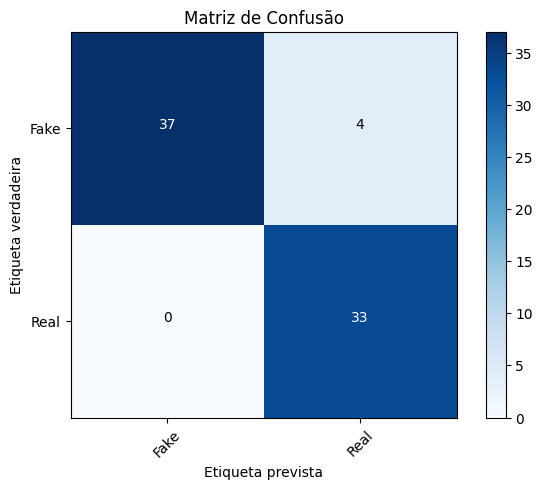

In [ ]:
# Divisão dos Dados
X = MD.drop('LABEL', axis=1)
y = MD['LABEL']

# Normalização dos Dados
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Divisão em Conjuntos de Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

def get_knn_classifier(n):
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)
  return knn

# Treinamento do Modelo
knn_classifier = get_knn_classifier(1)
# knn_classifier_10 = get_knn_classifier(10)
# knn_classifier_15 = get_knn_classifier(15)
# knn_classifier_20 = get_knn_classifier(20)

# Avaliação do Modelo
# Sugestão para análise: Troque o argumento n de knn_classifier para encontrar modelos com diferentes k-nearest neighbours
y_pred = knn_classifier.predict(X_test)

# Exibição de Métricas
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred,  ["Fake", "Real"])


Os resultados do treinamento do modelo KNN para a detecção de deepfakes em áudios são promissores. O modelo exibe boa precisão e recall para ambas as classes ("FAKE" e "REAL"). A análise detalhada revela uma precisão de 94% na detecção de deepfakes, indicando que, quando classifica um áudio como falso, o modelo está correto em 94% das vezes. O recall de 94% para áudios reais sugere que o modelo identifica corretamente a maioria dos áudios autênticos. A matriz de confusão mostra um número limitado de falsos positivos e falsos negativos.

# Testagem Ampla de Desempenho

Ao testar o modelo com áudios não utilizados no treinamento, pudemos avaliar sua capacidade de generalização. Isso é, sua habilidade de aplicar o conhecimento adquirido durante o treinamento para identificar com precisão deep fakes em amostras que nunca havia encontrado, refletindo assim o desempenho real do modelo em um ambiente operacional.

In [ ]:
oradores = ["biden", "obama", "musk", "taylor", "margot", "trump", "ryan", "linus"]

audios_escolhidos_2 = {}

arquivos_fake_escolhidos_2 = []

for orador in oradores:
    audios_orador = [arquivo for arquivo in csv_fakes if os.path.basename(arquivo).lower().startswith(orador) and arquivo not in audios_escolhidos[orador]]
    audios_escolhidos_2[orador] = random.sample(audios_orador, 4)
    arquivos_fake_escolhidos_2 += audios_escolhidos_2[orador]

# for orador, audios in audios_escolhidos_2.items():
#     print(f"Áudios escolhidos para {orador}:")
#     for audio in audios:
#         print(audio)

In [ ]:
test_dfs = []

for file_path in csv_reais + arquivos_fake_escolhidos_2:
    df_atual = pd.read_csv(file_path)
    test_dfs.append(df_atual)

new_test = pd.concat(test_dfs, ignore_index=True)
new_test = remover_colunas(new_test)

Acurácia nos novos dados: 0.7967567567567567

Relatório de Classificação:
               precision    recall  f1-score   support

        FAKE       1.00      0.75      0.85       740
        REAL       0.50      1.00      0.66       185

    accuracy                           0.80       925
   macro avg       0.75      0.87      0.76       925
weighted avg       0.90      0.80      0.82       925

Matriz de confusão, sem normalização


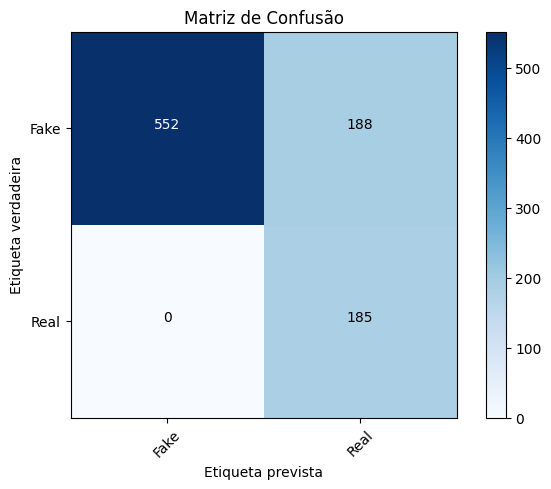

In [ ]:
# Normalizar os dados de teste
X_fake_test = new_test.drop('LABEL', axis=1)
y_fake_test = new_test['LABEL']

X_fake_test_normalized = scaler.fit_transform(X_fake_test)

# Prever rótulos usando o modelo k-NN
predictions_fake_test = knn_classifier.predict(X_fake_test)

# Avaliar a acurácia
accuracy_fake_test = accuracy_score(y_fake_test, predictions_fake_test)
print(f'Acurácia nos novos dados: {accuracy_fake_test}')
print("\nRelatório de Classificação:\n", classification_report(y_fake_test, predictions_fake_test))

plot_confusion_matrix(y_fake_test, predictions_fake_test, ["Fake", "Real"])

Para assegurar a imparcialidade e a precisão dos resultados, selecionamos uma série de áudios gerados por deep fake que não foram incorporados ao conjunto de treinamento do modelo para incluí-los no dataset de testes em uma análise posterior.

A inclusão de áudios deep fake não vistos anteriormente pelo modelo em nosso dataset de testes serviu para simular um cenário mais realista, no qual o modelo seria confrontado com novas amostras de deep fakes potencialmente desconhecidas após a sua implantação. Essa estratégia visa verificar a ocorrência de overfitting, uma condição onde o modelo performa excepcionalmente bem nos dados de treinamento devido à memorização, mas falha ao generalizar para novos dados.

Além disso, ao testar o modelo com áudios não utilizados no treinamento, pudemos avaliar sua capacidade de generalização. Isso é, sua habilidade de aplicar o conhecimento adquirido durante o treinamento para identificar com precisão deep fakes em amostras que nunca havia encontrado, refletindo assim o desempenho real do modelo em um ambiente operacional.

In [ ]:
test_dfs_2 = []

for file_path in csv_samples:
    df_atual = pd.read_csv(file_path)
    test_dfs_2.append(df_atual)

new_test_2 = pd.concat(test_dfs_2, ignore_index=True)
new_test_2 = pd.concat([new_test_2, new_test[-len(new_test_2):]], ignore_index=True)
new_test_2 = remover_colunas(new_test_2)

Acurácia nos novos dados: 0.581081081081081

Relatório de Classificação:
               precision    recall  f1-score   support

        FAKE       0.58      0.57      0.58        37
        REAL       0.58      0.59      0.59        37

    accuracy                           0.58        74
   macro avg       0.58      0.58      0.58        74
weighted avg       0.58      0.58      0.58        74

Matriz de confusão, sem normalização


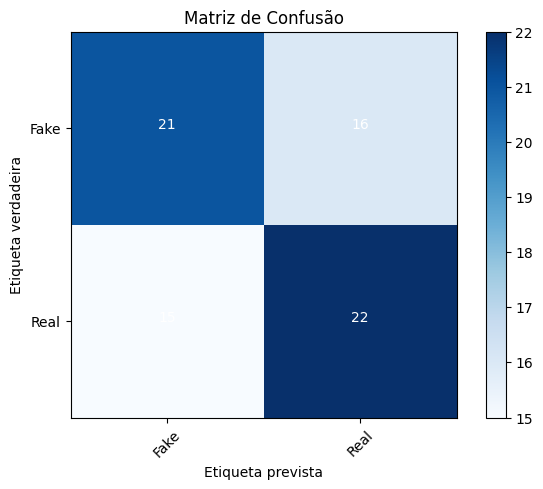

In [ ]:
# Normalizar os dados de teste
X_fake_test = new_test_2.drop('LABEL', axis=1)
y_fake_test = new_test_2['LABEL']

X_fake_test_normalized = scaler.fit_transform(X_fake_test)

# Teste com diferentes quantidades de vizinhos:
knn_classifier = get_knn_classifier(6)
# Prever rótulos usando o modelo k-NN
predictions_fake_test = knn_classifier.predict(X_fake_test)

# Avaliar a acurácia
accuracy_fake_test = accuracy_score(y_fake_test, predictions_fake_test)
print(f'Acurácia nos novos dados: {accuracy_fake_test}')
print("\nRelatório de Classificação:\n", classification_report(y_true=y_fake_test, y_pred=predictions_fake_test, zero_division=0.0))

plot_confusion_matrix(y_fake_test, predictions_fake_test, ["Fake", "Real"])

A fim de aprofundar as análises acerca do desempenho do modelo, coletamos um novo conjunto de áudios reais de discursos e pronunciamentos disponíveis. Com esses dados coletados, após processá-los e efetuar os tratamentos necessários, o modelo foi testado. Mais específicamente, esse teste foi realizado com o conjunto de áudios gerados por deep fake aos quais o modelo não teve acesso durante o treinamento, bem como o conjunto de áudios originais novo coletado.

Os áudios reais inclusos não correspondem às personas com base nas quais os treinamentos foram feitos, portanto, o modelo não possuía anteriormente nenhuma bae comparativa com essas vozes, diferentemente dos áudios gerados por deep fake. No caso desses, o modelo possuía previamente conhecimento acerca da pessoa dona daquela vóz, ao menos um áudio real sobre a mesma, pela forma com a qual o treinamento está estruturado.

Nesse cenário, o desempenho do modelo usado até o momento demonstrou sofrer uma grande redução, o que aponta que o mesmo não está generalizando bem as características geradas por deep fake com base no treinamento que foi dado. É fato que, ao ter trechos desses audios, ou outras amostras do mesmo orador incluídos na etapa de treinamento aumenta consideravelmente a capacidade do modelo de classificar os mesmos. Essa redução significativa também pode ser atribuída ao fato de haverem poucas amostras e, principalmente, haver pouca diversidade nas amostras usadas no teste, já que, caso o modelo esteja processando um áudio ao qual está negativamente enviesado, ele errará tantas predições quanto amostras advindas daquele áudio ( no cenário atual do projeto, costumam haver 7 ou 8 para cada áudio).

Em análises empíricas, modelos com diferentes valores de *nearest-neighbours* performam de maneiras diferentes nos cenários explorados até o momento de testes. Há indícios de que um número muito baixo de vizinhos ocasiona em overfitting, que aumenta a acurácia do modelo sobre certos conjuntos aos quais ele está previamente enviesado, mas reduz consideravelmente o desempenho do mesmo em outros conjuntos. No caso, o valor ideal encontrado nos testes que consideraram a acurácia sobre os áudios do mesmo conjunto foi 1 e diverge do valor ideal encontrado sobre áudios cujas características são novas para o modelo.

# CNN

In [ ]:
# lista_dfs = []

# for file_path in csv_reais + arquivos_fake_escolhidos + csv_reais:
#     df_atual = pd.read_csv(file_path)
#     lista_dfs.append(df_atual)

# MD = pd.concat(lista_dfs, ignore_index=True)

In [ ]:
# test_dfs = []

# for file_path in csv_reais + arquivos_fake_escolhidos_2:
#     df_atual = pd.read_csv(file_path)
#     test_dfs.append(df_atual)

# new_test = pd.concat(test_dfs, ignore_index=True)

In [ ]:
# test_dfs_2 = []

# for file_path in csv_samples:
#     df_atual = pd.read_csv(file_path)
#     test_dfs_2.append(df_atual)

# new_test_2 = pd.concat(test_dfs_2, ignore_index=True)
# new_test_2 = pd.concat([new_test_2, new_test[-len(new_test_2):]], ignore_index=True)

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def train_audio_model_from_df(dataframe):
    """
    Treina um modelo para classificar áudios em 'fake' ou 'real' baseado em um DataFrame.
    """
    # Separar features e labels
    X = dataframe.iloc[:, :-1].values  # Todas as colunas exceto a última
    y = dataframe.iloc[:, -1].values  # A última coluna contém as labels

    # Codificar labels 'REAL' e 'FAKE' numericamente
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)  # Converter para one-hot encoding

    # Dividir os dados em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

    # Reformatar os dados para o formato esperado pela CNN 1D
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Construir o modelo
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(y_categorical.shape[1], activation='sigmoid')
    ])

    # Compilar o modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    return model, history

# Supondo que 'df' seja o seu DataFrame contendo as features e a coluna 'label'

model, history = train_audio_model_from_df(MD.sample(frac=1).reset_index(drop=False))

Epoch 1/20
19/19 [==============================] - 2s 28ms/step - loss: 41.2357 - accuracy: 0.4983 - val_loss: 28.0116 - val_accuracy: 0.5338
Epoch 2/20
19/19 [==============================] - 0s 13ms/step - loss: 17.5190 - accuracy: 0.5709 - val_loss: 18.8688 - val_accuracy: 0.4662
Epoch 3/20
19/19 [==============================] - 0s 12ms/step - loss: 5.7708 - accuracy: 0.6486 - val_loss: 9.5936 - val_accuracy: 0.4662
Epoch 4/20
19/19 [==============================] - 0s 15ms/step - loss: 3.5972 - accuracy: 0.6419 - val_loss: 4.0004 - val_accuracy: 0.6824
Epoch 5/20
19/19 [==============================] - 0s 12ms/step - loss: 3.3269 - accuracy: 0.6757 - val_loss: 7.9389 - val_accuracy: 0.6689
Epoch 6/20
19/19 [==============================] - 0s 13ms/step - loss: 3.4447 - accuracy: 0.7787 - val_loss: 1.6963 - val_accuracy: 0.6689
Epoch 7/20
19/19 [==============================] - 0s 11ms/step - loss: 1.3905 - accuracy: 0.7905 - val_loss: 1.4595 - val_accuracy: 0.7365
Epoch 8/2

29/29 [==============================] - 0s 2ms/step
Acurácia: 0.4703
Precisão: 0.6279
Matriz de confusão, sem normalização


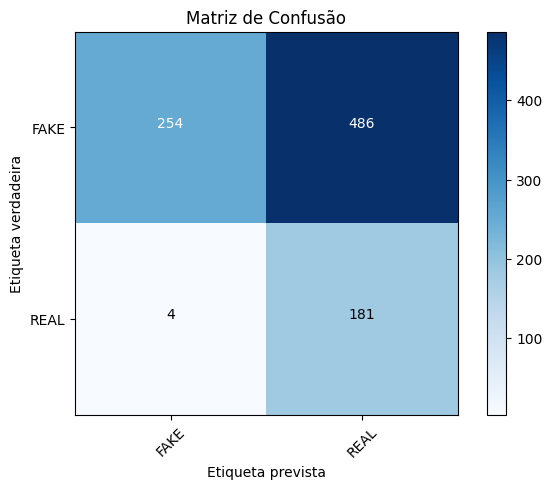

In [ ]:
def evaluate_model(model, test_dataframe):
    """
    Avalia o modelo treinado em um dataframe de teste, calculando e imprimindo a acurácia e precisão.
    """
    # Separar features e labels
    X_test = test_dataframe.iloc[:, :-1].values  # Todas as colunas exceto a última
    y_test = test_dataframe.iloc[:, -1].values  # A última coluna contém as labels

    # Codificar labels 'REAL' e 'FAKE' numericamente
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)
    y_test_categorical = to_categorical(y_test_encoded)  # Converter para one-hot encoding

    # Reformatar os dados para o formato esperado pela CNN 1D
    X_test = X_test[..., np.newaxis]

    # Fazer previsões
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test_categorical, axis=1)

    # Calcular acurácia e precisão
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='macro')

    print(f'Acurácia: {accuracy:.4f}')
    print(f'Precisão: {precision:.4f}')

    plot_confusion_matrix(y_test_encoded, predicted_classes, classes=["FAKE", "REAL"])

    return accuracy, precision

accuracy, precision = evaluate_model(model, new_test.sample(frac=1).reset_index(drop=False))



3/3 [==============================] - 0s 4ms/step
Acurácia: 0.5541
Precisão: 0.5593
Matriz de confusão, sem normalização


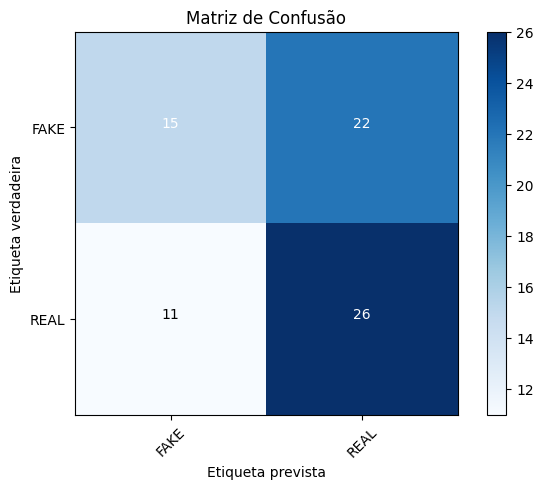

In [ ]:
accuracy, precision = evaluate_model(model, new_test_2.sample(frac=1).reset_index(drop=False))